# Best Available Pixel Composite in OpenEO

In this notebook a composite image is created based on the Best Available Pixel (BAP) method in OpenEO. The BAP score is calculated via using a UDF, which gives a lot of flexibility on the calculation methodology. The BAP score is a weighted average of three scores:
- **Distance-to-Cloud Score**: Pixels that are clouds are given score 0. Pixels that are moren than 50 pixels - calculated with the Manhattan distance measure - away from a cloud pixel are given score 1. The pixels in between are given a score versus distance-to-cloud that follows a Gaussian shape.
- **Coverage Score**: Per date, the percentage of all pixels that are classified as a cloud over the entire spatial extent is calculated. The Coverage Score is then equal to 1 - the cloud percentage.
- **Date Score**: In order to favor pixels that are observed in the middle of a month, a date score is calculated, which follows a Gaussian shape. I.e. the largest scores are given for days in the middle of the month, the lowest scores are given for days at the beginning and end of the month. 

The final BAP score is a weighted average of the three aforementioned scores. The weights are 1, 0.5 and 0.8 for the Distance-to-Cloud, Coverage and Date Score respectively. 

In this notebook the BAP score is calculated by using a UDF. This gives the user a lot of flexibility to tweak one or more of the parameters above. For example, the user might want to increase the maximum distance of 50 pixels, use another distance measure, use other weights to aggregate the score, or even add or remove a component to the final score. This can all be done by adjusting the UDF code.

## Score Calculation

First a sample period and region are defined, along with the maximum cloud cover.

In [2]:
spatial_extent = {'west': 4.45, 'east': 4.50, 'south': 51.16, 'north': 51.17, 'crs': 'epsg:4326'}
temporal_extent = ["2022-06-04", "2022-08-01"]
max_cloud_cover = 75
spatial_resolution = 20
block_size = 256
total_weights = 3.8

In [3]:
import openeo
import xarray
import numpy as np

from openeo.processes import if_, is_nan

In [4]:
c=openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [5]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["SCL"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution)

Create a cloud binary to later mask out clouds

In [6]:
classification = scl.band("SCL")
binary = (classification == 0) | (classification == 3) | (classification == 8) | (classification == 9) | (classification == 10) 

Next, make sure that all pixels which are NaN are cast to zero. This is necessary for later.

In [7]:
scl = scl.apply(lambda x: if_(is_nan(x), 0, x))

Using a UDF, the SCL layer is converted into a score for each pixel. This score is the weighted average of the day-of-year, distance-to-cloud and coverage score.

In [8]:
score_scl = scl.apply_neighborhood(
    process=openeo.UDF.from_file("udf_scl_score.py"),
    size=[{'dimension': 'x', 'unit': 'px', 'value': block_size}, {'dimension': 'y', 'unit': 'px', 'value': block_size}],
    overlap=[{'dimension': 'x', 'unit': 'px', 'value': block_size/16}, {'dimension': 'y', 'unit': 'px', 'value': block_size/16}]
)
score_scl = score_scl.rename_labels('bands', ['score'])

Next, to identify clouds that are not or wrongly classified in the SCL layer, the B01 layer is loaded. Typically haze and clouds will have a higher reflectance in this band. A fourth component to the BAP score is calculated using this band.

In [9]:
b01 = c.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["B01"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution)

In [10]:
score_b01 = b01.apply_neighborhood(
    process=openeo.UDF.from_file("udf_b01_score.py"),
    size=[{'dimension': 'x', 'unit': 'px', 'value': block_size}, {'dimension': 'y', 'unit': 'px', 'value': block_size}],
    overlap=[{'dimension': 'x', 'unit': 'px', 'value': block_size/16}, {'dimension': 'y', 'unit': 'px', 'value': block_size/16}]
)
score_b01 = score_b01.rename_labels('bands', ['score'])

The final BAP score is the weighted average of the two scores. 

In [11]:
score = (score_scl + score_b01) / total_weights

Next, the results is download and plotted. This is not a necessary step, but is just shown for illustration.

In [12]:
score.download('./results/score_udf.nc')

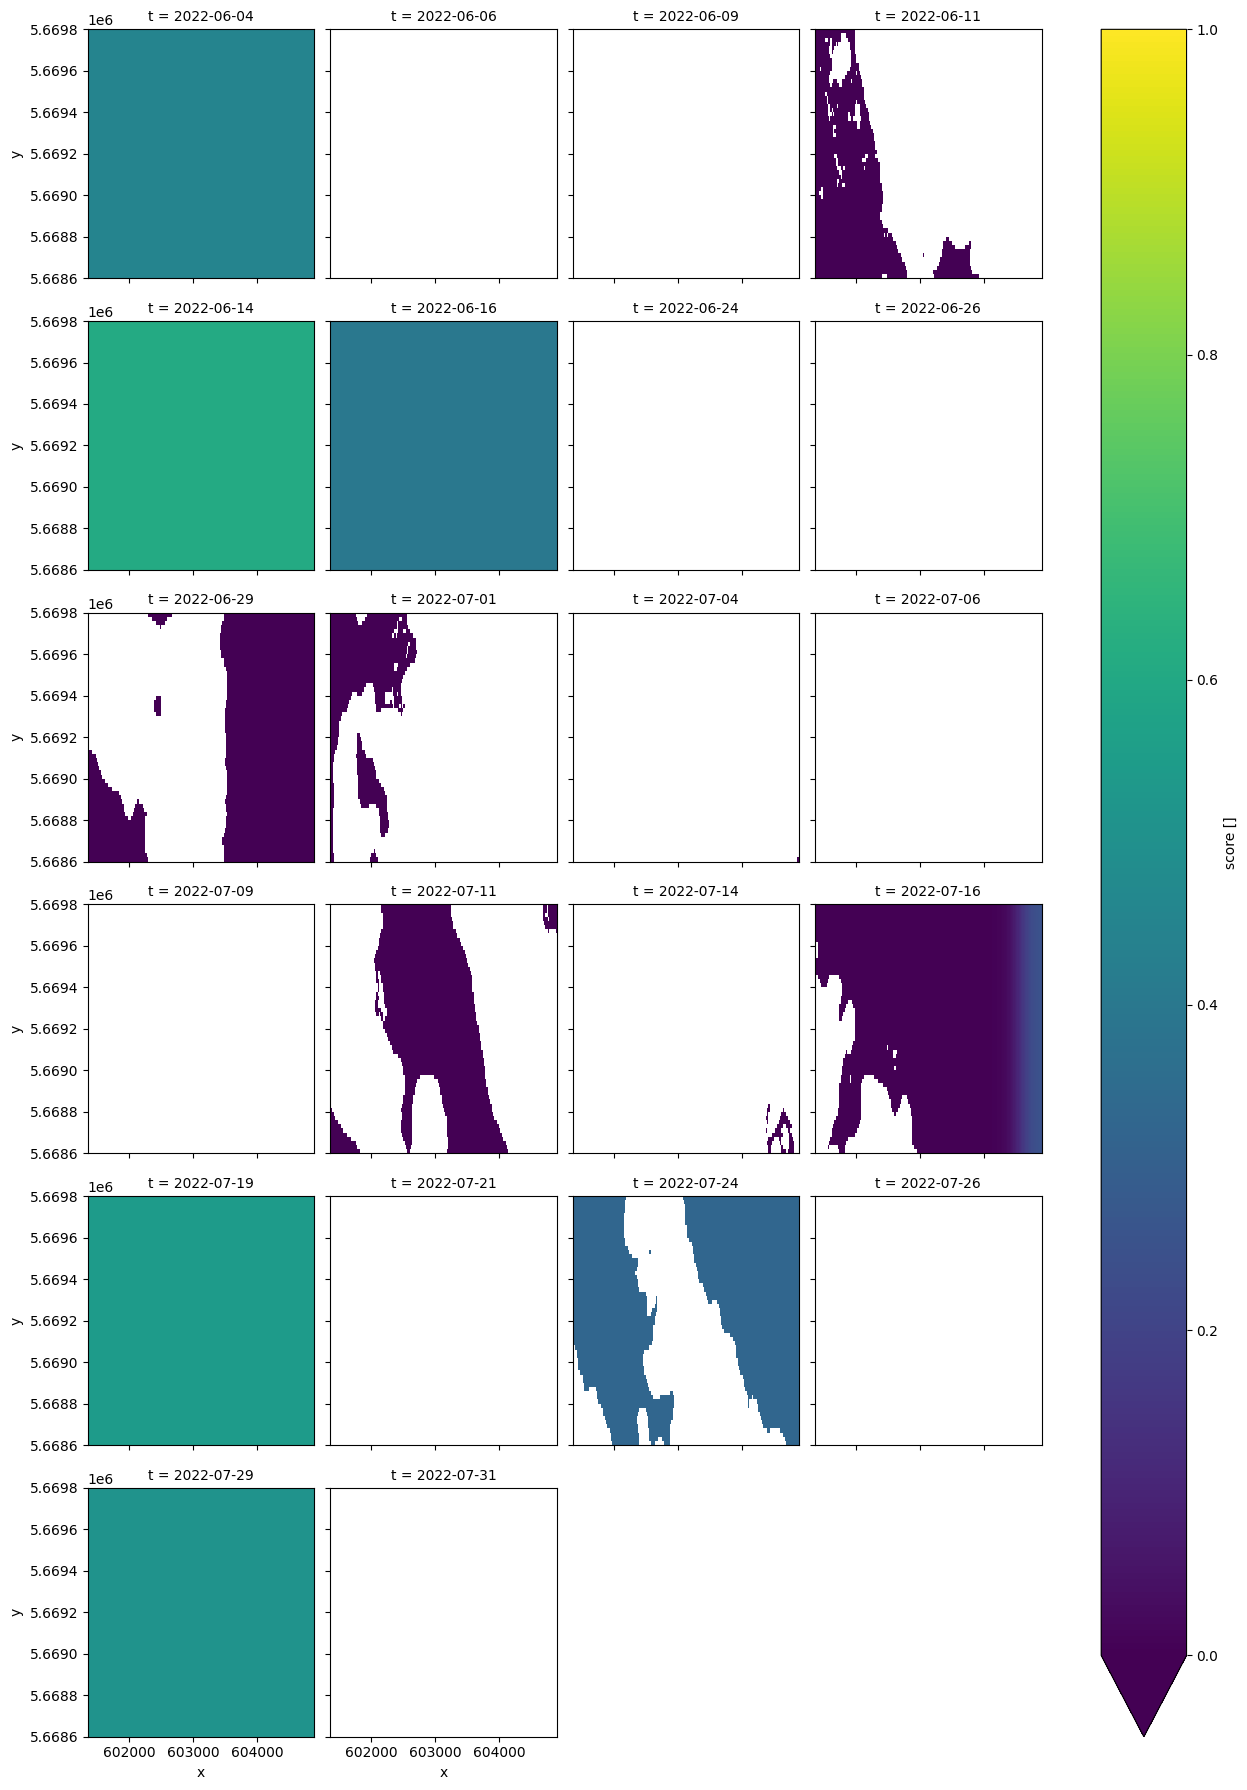

In [13]:
score_ds = xarray.open_dataset('./results/score_udf.nc')
score_ds['score'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

## Masking

Next, a mask is created. This serves to mask every pixel, except the one with the highest score, for each month.

In [14]:
def max_score_selection(score):
    max_score = score.max()
    return score.array_apply(lambda x:x!=max_score)

rank_mask = score.apply_neighborhood(
        max_score_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

rank_mask = rank_mask.band('score')

Again, the results are downloaded and plotted merely for illustrative purposes only.

In [15]:
rank_mask.download("./results/rank_mask_udf.nc")

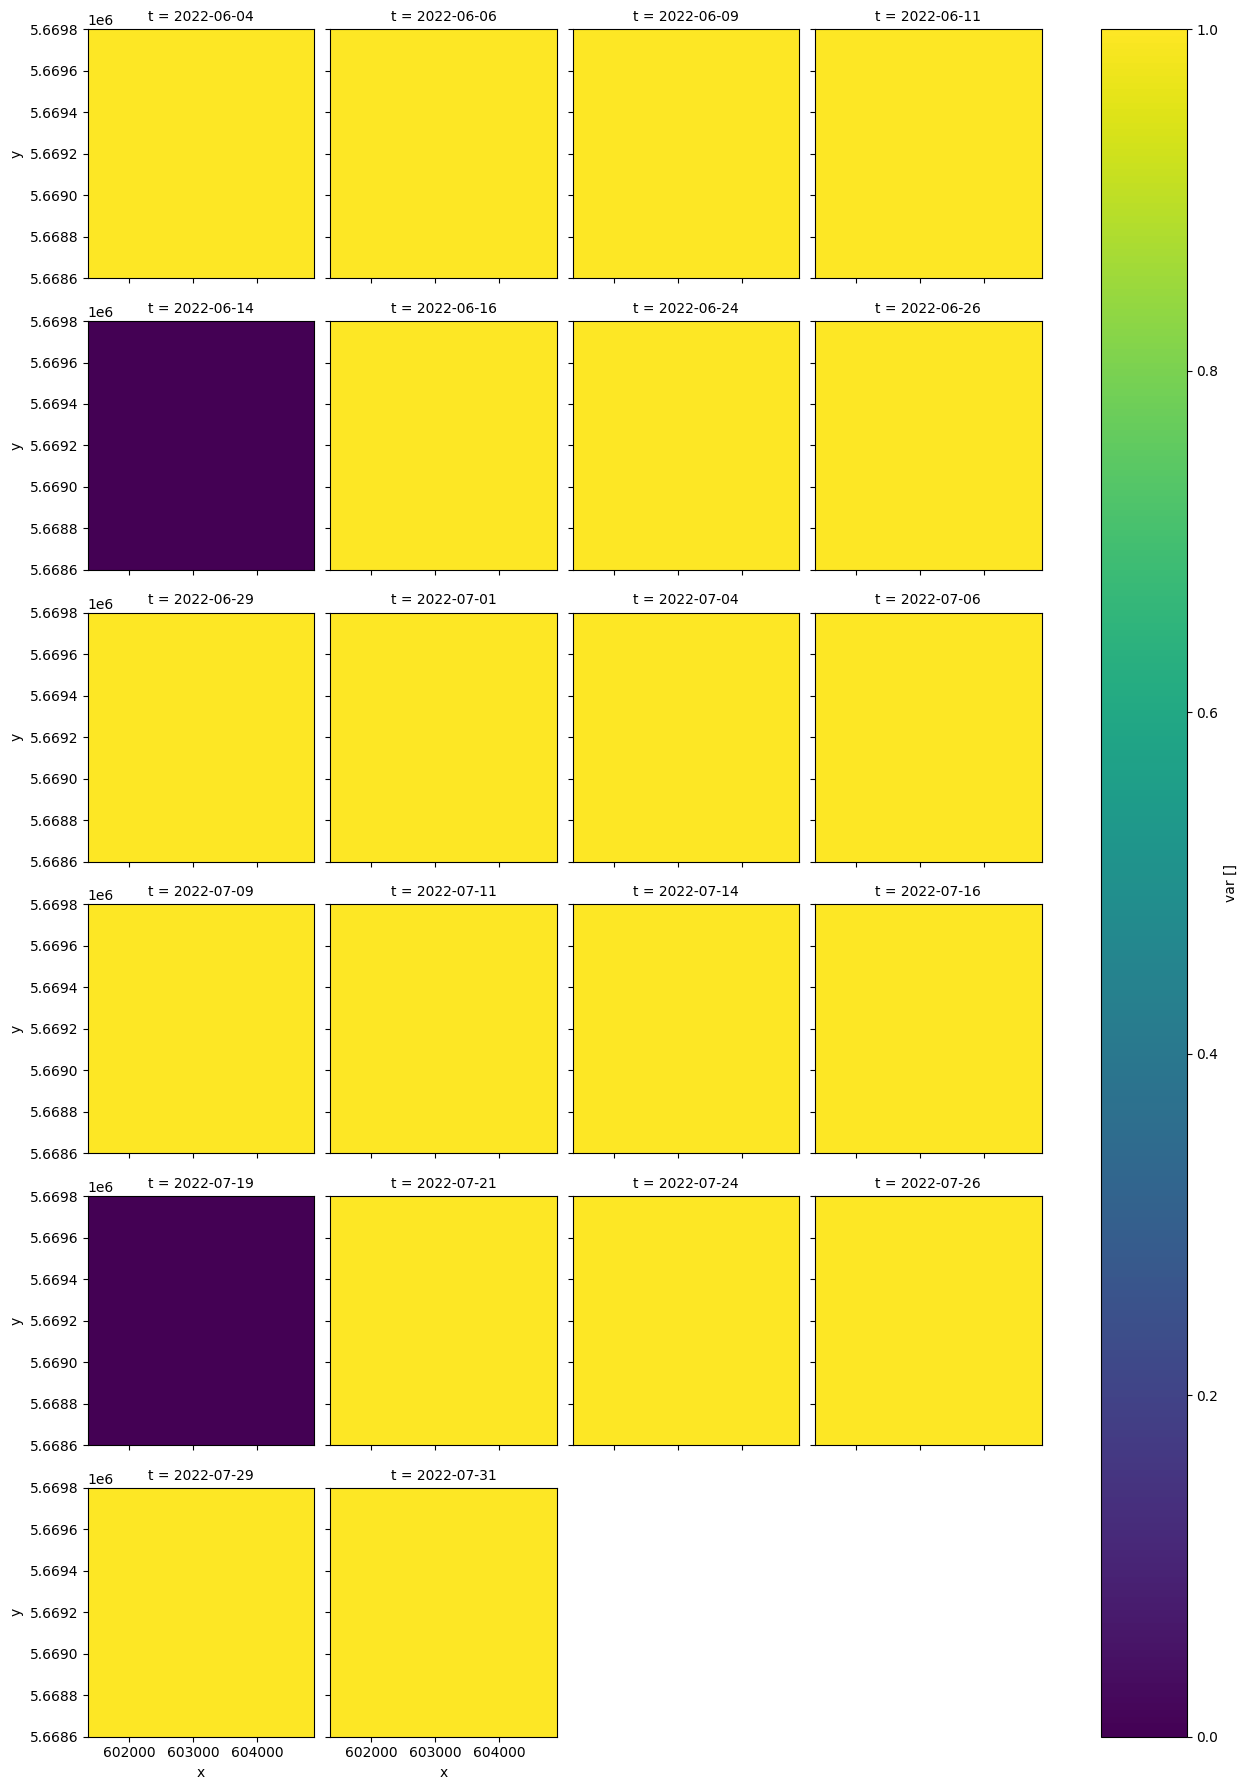

In [17]:
mask_ds = xarray.open_dataset('./results/rank_mask_udf.nc')
mask_ds['var'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

## Compositing

Next, some bands of interest from Sentinel-2 are loaded. They are then masked by the BAP mask constructed above. Next, based on the cloud binary derived from the SCL layer, the bands are masked, so that, in the case there are still clouds in the final composite, these are also masked out. Then they are aggregated per month, to obtain a composite image per month. By using the "first" process as an aggregator, the situation where there are potentially more than one days in a month selected by the algorithm is immediately handled.

In [18]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = temporal_extent,
    spatial_extent = spatial_extent,
    bands = ["B02", "B03","B04"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution)

composite = rgb_bands.mask(rank_mask.resample_cube_spatial(rgb_bands)).mask(binary).aggregate_temporal_period("month","first")

Next, the final results are downloaded and the composite images are shown.

In [19]:
composite.execute_batch('./results/composoite_udf.nc')

0:00:00 Job 'j-2402011614a949e2912dbbe24e32a1ef': send 'start'
0:00:32 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:00:37 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:00:44 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:00:52 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:01:03 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:01:15 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:01:31 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:01:50 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:02:14 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:02:45 Job 'j-2402011614a949e2912dbbe24e32a1ef': queued (progress N/A)
0:03:22 Job 'j-2402011614a949e2912dbbe24e32a1ef': running (progress N/A)
0:04:09 Job 'j-2402011614a949e2912dbbe24e32a1ef': running (progress N/A)
0:05:08 Job 'j-2402011614a949e2912dbbe24e32a1ef': running (progress N/A

<BatchJob job_id='j-2402011614a949e2912dbbe24e32a1ef'>

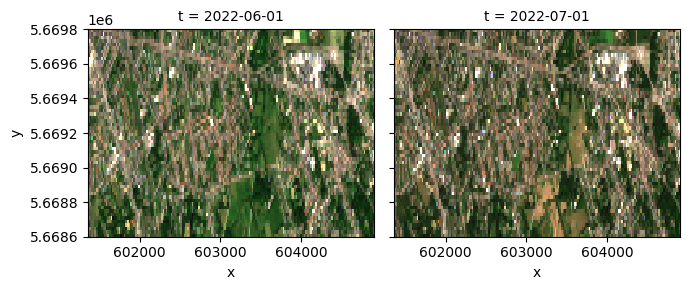

In [23]:
composite_ds = xarray.open_dataset('./results/composite_udf.nc')
rgb_array=composite_ds.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
xarray.plot.imshow(rgb_array,vmin=0,vmax=0.18,rgb="bands",col='t',col_wrap=2)